<a href="https://colab.research.google.com/github/majdsuleiman98/Integrating-Visual-and-Textual-Features-for-House-Price-Estimation/blob/main/House_Pricing_Multi_Input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import pickle
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Concatenate
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/House_Multi_Input.zip','r') as obj:
  obj.extractall('/content/drive/MyDrive')

In [2]:
path = '/content/drive/MyDrive/Houses Dataset'
print(path)
print(len(os.listdir(path)))

/content/drive/MyDrive/Houses Dataset
2142


In [3]:
column_names = ['Number of Bedrooms', 'Number of bathrooms', 'Area', 'Zipcode', 'Price']
data = pd.read_csv(path + '/HousesInfo.txt',sep=' ',names=column_names)
data.shape

(535, 5)

In [4]:
data.head()

,Number of Bedrooms,Number of bathrooms,Area,Zipcode,Price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [5]:
data.tail()

,Number of Bedrooms,Number of bathrooms,Area,Zipcode,Price
530,5,2.0,2066,94531,399900
531,4,3.5,9536,94531,460000
532,3,2.0,2014,94531,407000
533,4,3.0,2312,94531,419000
534,5,3.0,3796,94531,615000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Number of Bedrooms   535 non-null    int64  
 1   Number of bathrooms  535 non-null    float64
 2   Area                 535 non-null    int64  
 3   Zipcode              535 non-null    int64  
 4   Price                535 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 21.0 KB


In [7]:
data.describe()

,Number of Bedrooms,Number of bathrooms,Area,Zipcode,Price
count,535.000000,535.000000,535.000000,535.000000,5.350000e+02
mean,3.377570,2.664953,2364.904673,90937.768224,5.893628e+05
std,1.160952,0.995077,1224.556982,7141.857452,5.090261e+05
min,1.000000,1.000000,701.000000,36372.000000,2.200000e+04
25%,3.000000,2.000000,1440.000000,92276.000000,2.492000e+05
50%,3.000000,2.500000,2078.000000,92880.000000,5.290000e+05
75%,4.000000,3.000000,3067.500000,93510.000000,7.285000e+05
max,10.000000,7.000000,9583.000000,98021.000000,5.858000e+06


#Data Analysis

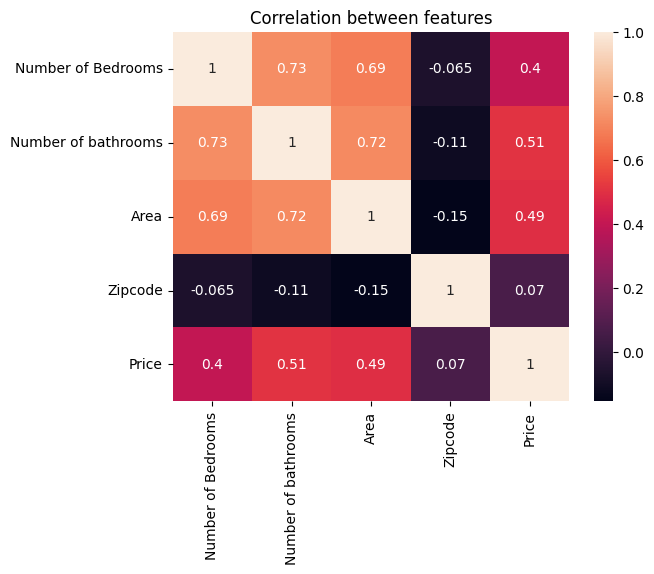

In [ ]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix,annot=True)
plt.title('Correlation between features')
plt.show()

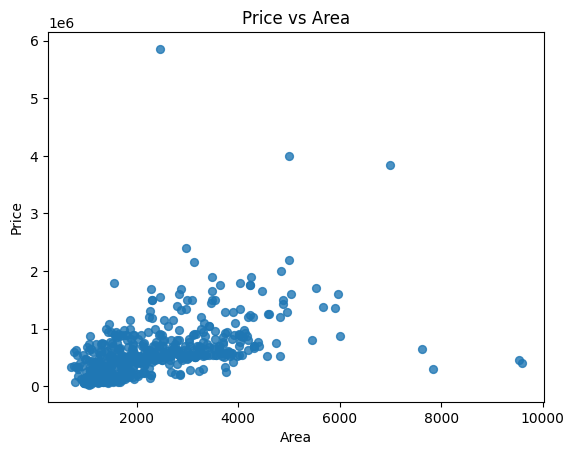

In [ ]:
data.plot(kind='scatter',x='Area',y='Price',s=32, alpha=.8)
plt.title('Price vs Area')
plt.xlabel('Area')
plt.ylabel('Price')
plt.show()

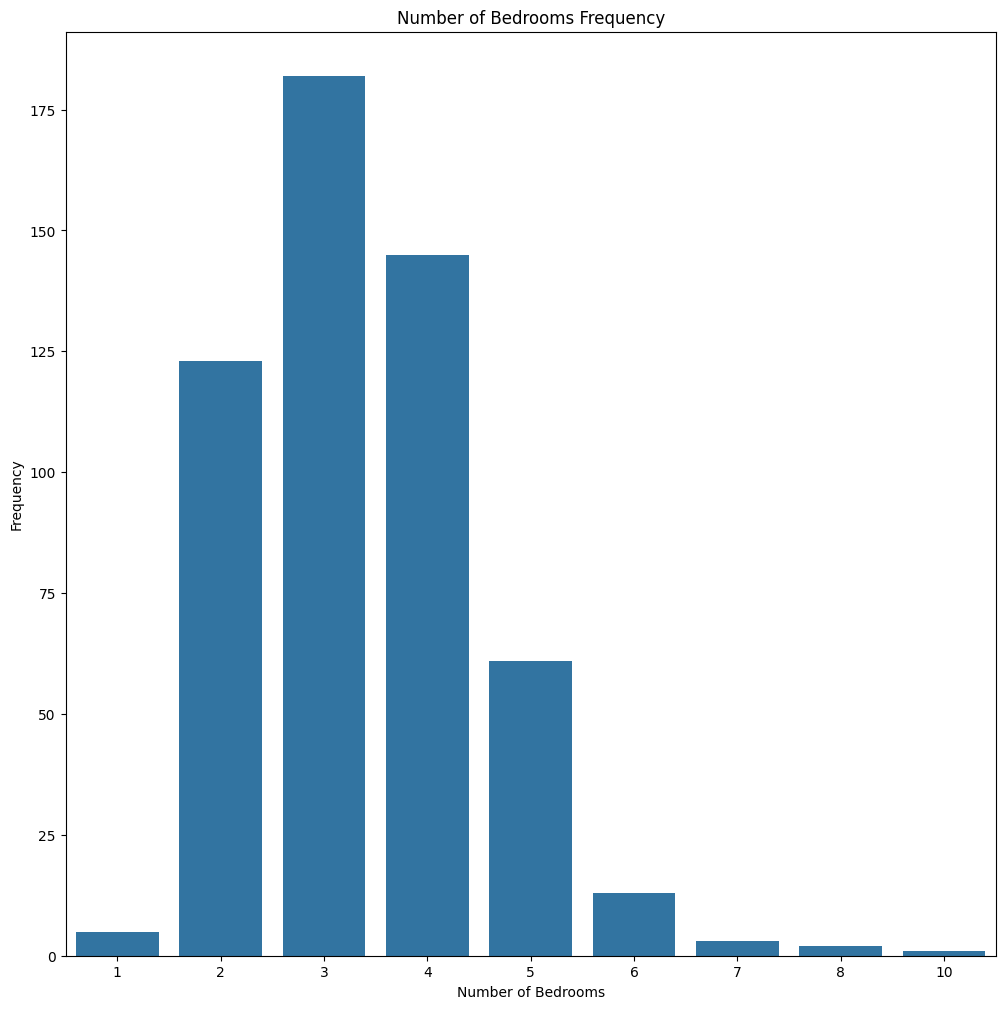

In [ ]:
plt.figure(figsize=(12,12))
sns.countplot(data,x='Number of Bedrooms')
plt.title('Number of Bedrooms Frequency')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Frequency')
plt.show()


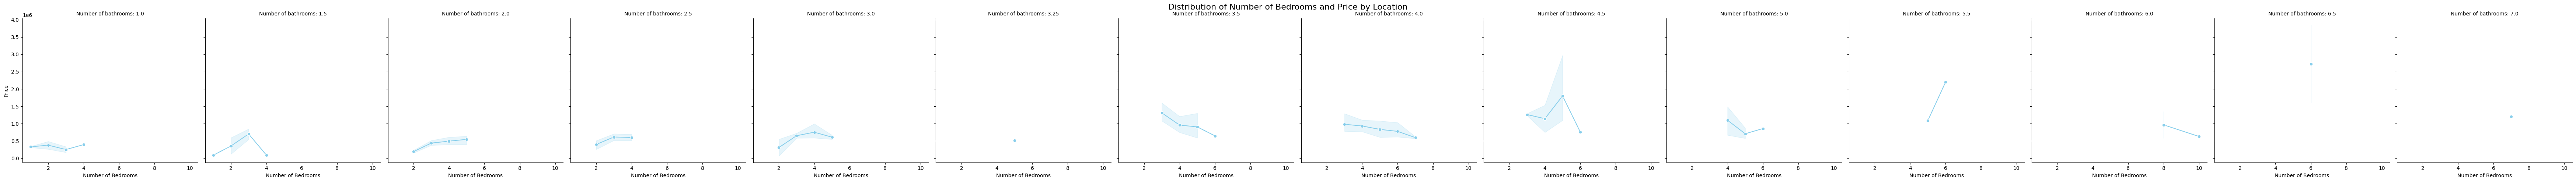

In [ ]:
g = sns.FacetGrid(data, col="Number of bathrooms", height=5)

g.map(sns.lineplot, "Number of Bedrooms", "Price",marker='o', color='skyblue')

g.set_titles(col_template="Number of bathrooms: {col_name}")
g.set_axis_labels("Number of Bedrooms", "Price")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Distribution of Number of Bedrooms and Price by Location', fontsize=16)

plt.show()

In [ ]:
def Print_Images_Of_House(number):
  images = glob.glob(path + "/*.jpg")
  print(f"Price of the house number {number} is : ",data.iloc[int(number)-1,-1])
  for image in images:
    name = image.split("/")[-1]
    num = name.split("_")[0]
    if int(num) == number:
      plt.subplots(figsize=(6,6))
      plt.imshow(plt.imread(image))
      plt.title(f'{name.split("_")[1]}')
      plt.axis('off')
      plt.show()

Price of the house number 10 is :  1500000


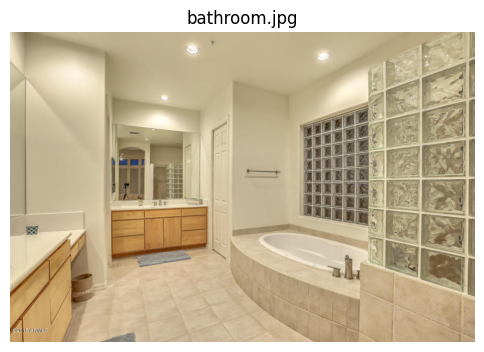

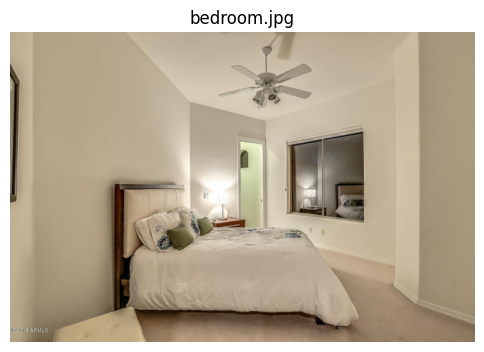

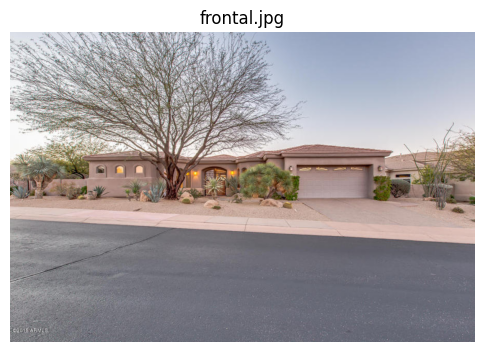

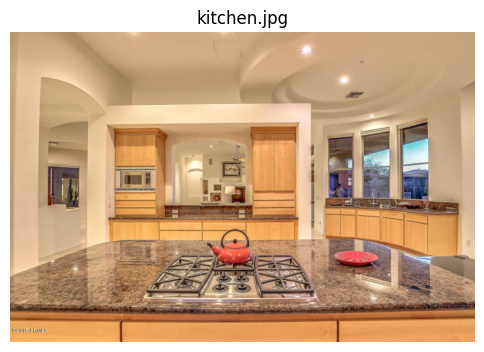

In [ ]:
Print_Images_Of_House(10)

In [ ]:
def extract_key_asstr(path):
  name = path.split("/")[-1]
  key = name.split("_")[0]
  return key

def extract_key_asint(path):
  name = path.split("/")[-1]
  key = name.split("_")[0]
  return int(key)

#Extract Features From Images

In [ ]:
model = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))
model = Model(inputs=model.inputs,outputs=model.layers[-2].output)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
images = glob.glob(path + '/*.jpg')
sorted_images = sorted(images,key=extract_key_asint)
print(sorted_images[:12])

['/content/drive/MyDrive/Houses Dataset/1_bathroom.jpg', '/content/drive/MyDrive/Houses Dataset/1_bedroom.jpg', '/content/drive/MyDrive/Houses Dataset/1_frontal.jpg', '/content/drive/MyDrive/Houses Dataset/1_kitchen.jpg', '/content/drive/MyDrive/Houses Dataset/2_bathroom.jpg', '/content/drive/MyDrive/Houses Dataset/2_bedroom.jpg', '/content/drive/MyDrive/Houses Dataset/2_frontal.jpg', '/content/drive/MyDrive/Houses Dataset/2_kitchen.jpg', '/content/drive/MyDrive/Houses Dataset/3_bathroom.jpg', '/content/drive/MyDrive/Houses Dataset/3_bedroom.jpg', '/content/drive/MyDrive/Houses Dataset/3_frontal.jpg', '/content/drive/MyDrive/Houses Dataset/3_kitchen.jpg']


In [ ]:
features = dict()
images = glob.glob(path + '/*.jpg')
sorted_images = sorted(images,key=extract_key_asint)
for image in tqdm(images):
  key = extract_key_asstr(image)
  if key not in features:
    features[key] = list()
  img = load_img(image,target_size=(224,224))
  img = img_to_array(img)
  img = np.expand_dims(img,axis=0)
  img = preprocess_input(img)
  feature = model.predict(img,verbose=0)
  features[key].append(feature)

100%|██████████| 2140/2140 [03:57<00:00,  9.00it/s]


In [ ]:
len(features)

535

#Processing Image Features To Feed The Model


In [ ]:
image_features = []
for key in sorted(features.keys()):
    feature_list = features[key]
    if len(feature_list) != 4:
        raise ValueError(f"Expected 4 features for key {key}, but got {len(feature_list)}")

    concatenated_features = np.concatenate(feature_list, axis=-1)  # Shape (1, 16384)
    image_features.append(concatenated_features.flatten())  # Flatten to 1D array


image_features_np = np.array(image_features)
print(image_features_np.shape)  # Should be (535, 16384)

(535, 16384)


In [ ]:
pickle.dump(features,open(os.path.join(path,'features.pkl'),'wb'))

In [ ]:
with open(os.path.join(path,'features.pkl','rb')) as f:
  features = pickle.load(f)

# Check Null Values


In [ ]:
data.isnull().sum()

,0
Number of Bedrooms,0
Number of bathrooms,0
Area,0
Zipcode,0
Price,0


In [ ]:
data.columns

Index(['Number of Bedrooms', 'Number of bathrooms', 'Area', 'Zipcode',
       'Price'],
      dtype='object')

# Encodeing ZipCode Column
# Target Encoding



In [ ]:
zipcode_mean_price = data.groupby(['Zipcode'])['Price'].mean().to_dict()
zipcode_mean_price

{36372: 865200.0,
 60002: 267966.6666666667,
 60016: 261950.0,
 60046: 289900.0,
 62025: 384950.0,
 62034: 209900.0,
 62088: 119000.0,
 62214: 180450.0,
 62234: 191042.85714285713,
 62249: 339900.0,
 81418: 417000.0,
 81521: 214900.0,
 81524: 480418.0909090909,
 85255: 1082691.6666666667,
 85262: 1242833.3333333333,
 85266: 973947.8181818182,
 85331: 740000.0,
 85377: 1341333.3333333333,
 90038: 1550000.0,
 90211: 1500000.0,
 90265: 1695000.0,
 90803: 1299000.0,
 91752: 551300.0,
 91901: 732171.84375,
 91915: 360000.0,
 92021: 597290.9090909091,
 92040: 1350000.0,
 92253: 400000.0,
 92276: 124416.38,
 92543: 284900.0,
 92677: 1051038.3461538462,
 92692: 682550.0,
 92802: 535866.6666666666,
 92880: 559302.5510204082,
 93105: 895000.0,
 93111: 1493909.0,
 93314: 310000.0,
 93446: 581401.7592592592,
 93510: 628142.1,
 93720: 89900.0,
 93924: 1150000.0,
 94501: 814594.4634146341,
 94531: 438572.6818181818,
 94565: 540000.0,
 94568: 303590.0,
 95008: 999000.0,
 95220: 1031249.8,
 96019: 360

In [ ]:
len(zipcode_mean_price)

49

In [ ]:
data['Zipcode_Mean_Price'] = data['Zipcode'].map(zipcode_mean_price)

In [ ]:
data.head()

,Number of Bedrooms,Number of bathrooms,Area,Zipcode,Price,Zipcode_Mean_Price
0,4,4.0,4053,85255,869500,1.082692e+06
1,4,3.0,3343,36372,865200,8.652000e+05
2,3,4.0,3923,85266,889000,9.739478e+05
3,5,5.0,4022,85262,910000,1.242833e+06
4,3,4.0,4116,85266,971226,9.739478e+05


# Data Normalization

In [ ]:
X = data.drop(['Price','Zipcode'],axis=1)
y = data['Price']

In [ ]:
numeric_columns = ['Number of Bedrooms','Number of bathrooms','Zipcode_Mean_Price','Area']
normlizer = MinMaxScaler()
normlized_X = normlizer.fit_transform(X[numeric_columns])
normlized_y = normlizer.fit_transform(y.values.reshape(-1,1))

In [ ]:
print(normlized_X.shape)
print(normlized_y.shape)

(535, 4)
(535, 1)


In [ ]:
print(normlized_X[:5])
print(normlized_y[:5])

[[0.33333333 0.5        0.61852325 0.37739248]
 [0.33333333 0.33333333 0.48302286 0.29745553]
 [0.22222222 0.5        0.55077429 0.36275614]
 [0.44444444 0.66666667 0.71829377 0.37390227]
 [0.22222222 0.5        0.55077429 0.38448548]]
[[0.14521933]
 [0.14448252]
 [0.14856066]
 [0.15215901]
 [0.1626501 ]]


# Build The Model

In [ ]:
# Image Features Branch
input_1 = Input(shape=(16384,))
dense_1 = Dense(512,activation='relu')(input_1)
dense_2 = Dense(256,activation='relu')(dense_1)

# Tabular Data Branch
input_2 = Input(shape=(4,))
dense_3 = Dense(32,activation='relu')(input_2)
dense_4 = Dense(16,activation='relu')(dense_3)

concat = Concatenate()([dense_2,dense_4])
dense_5 = Dense(8,activation='relu')(concat)
output = Dense(1,activation='linear')(dense_5)

model = Model(inputs=[input_1,input_2],outputs=output)
model.compile(optimizer='adam',loss='mse',metrics=['mae'])

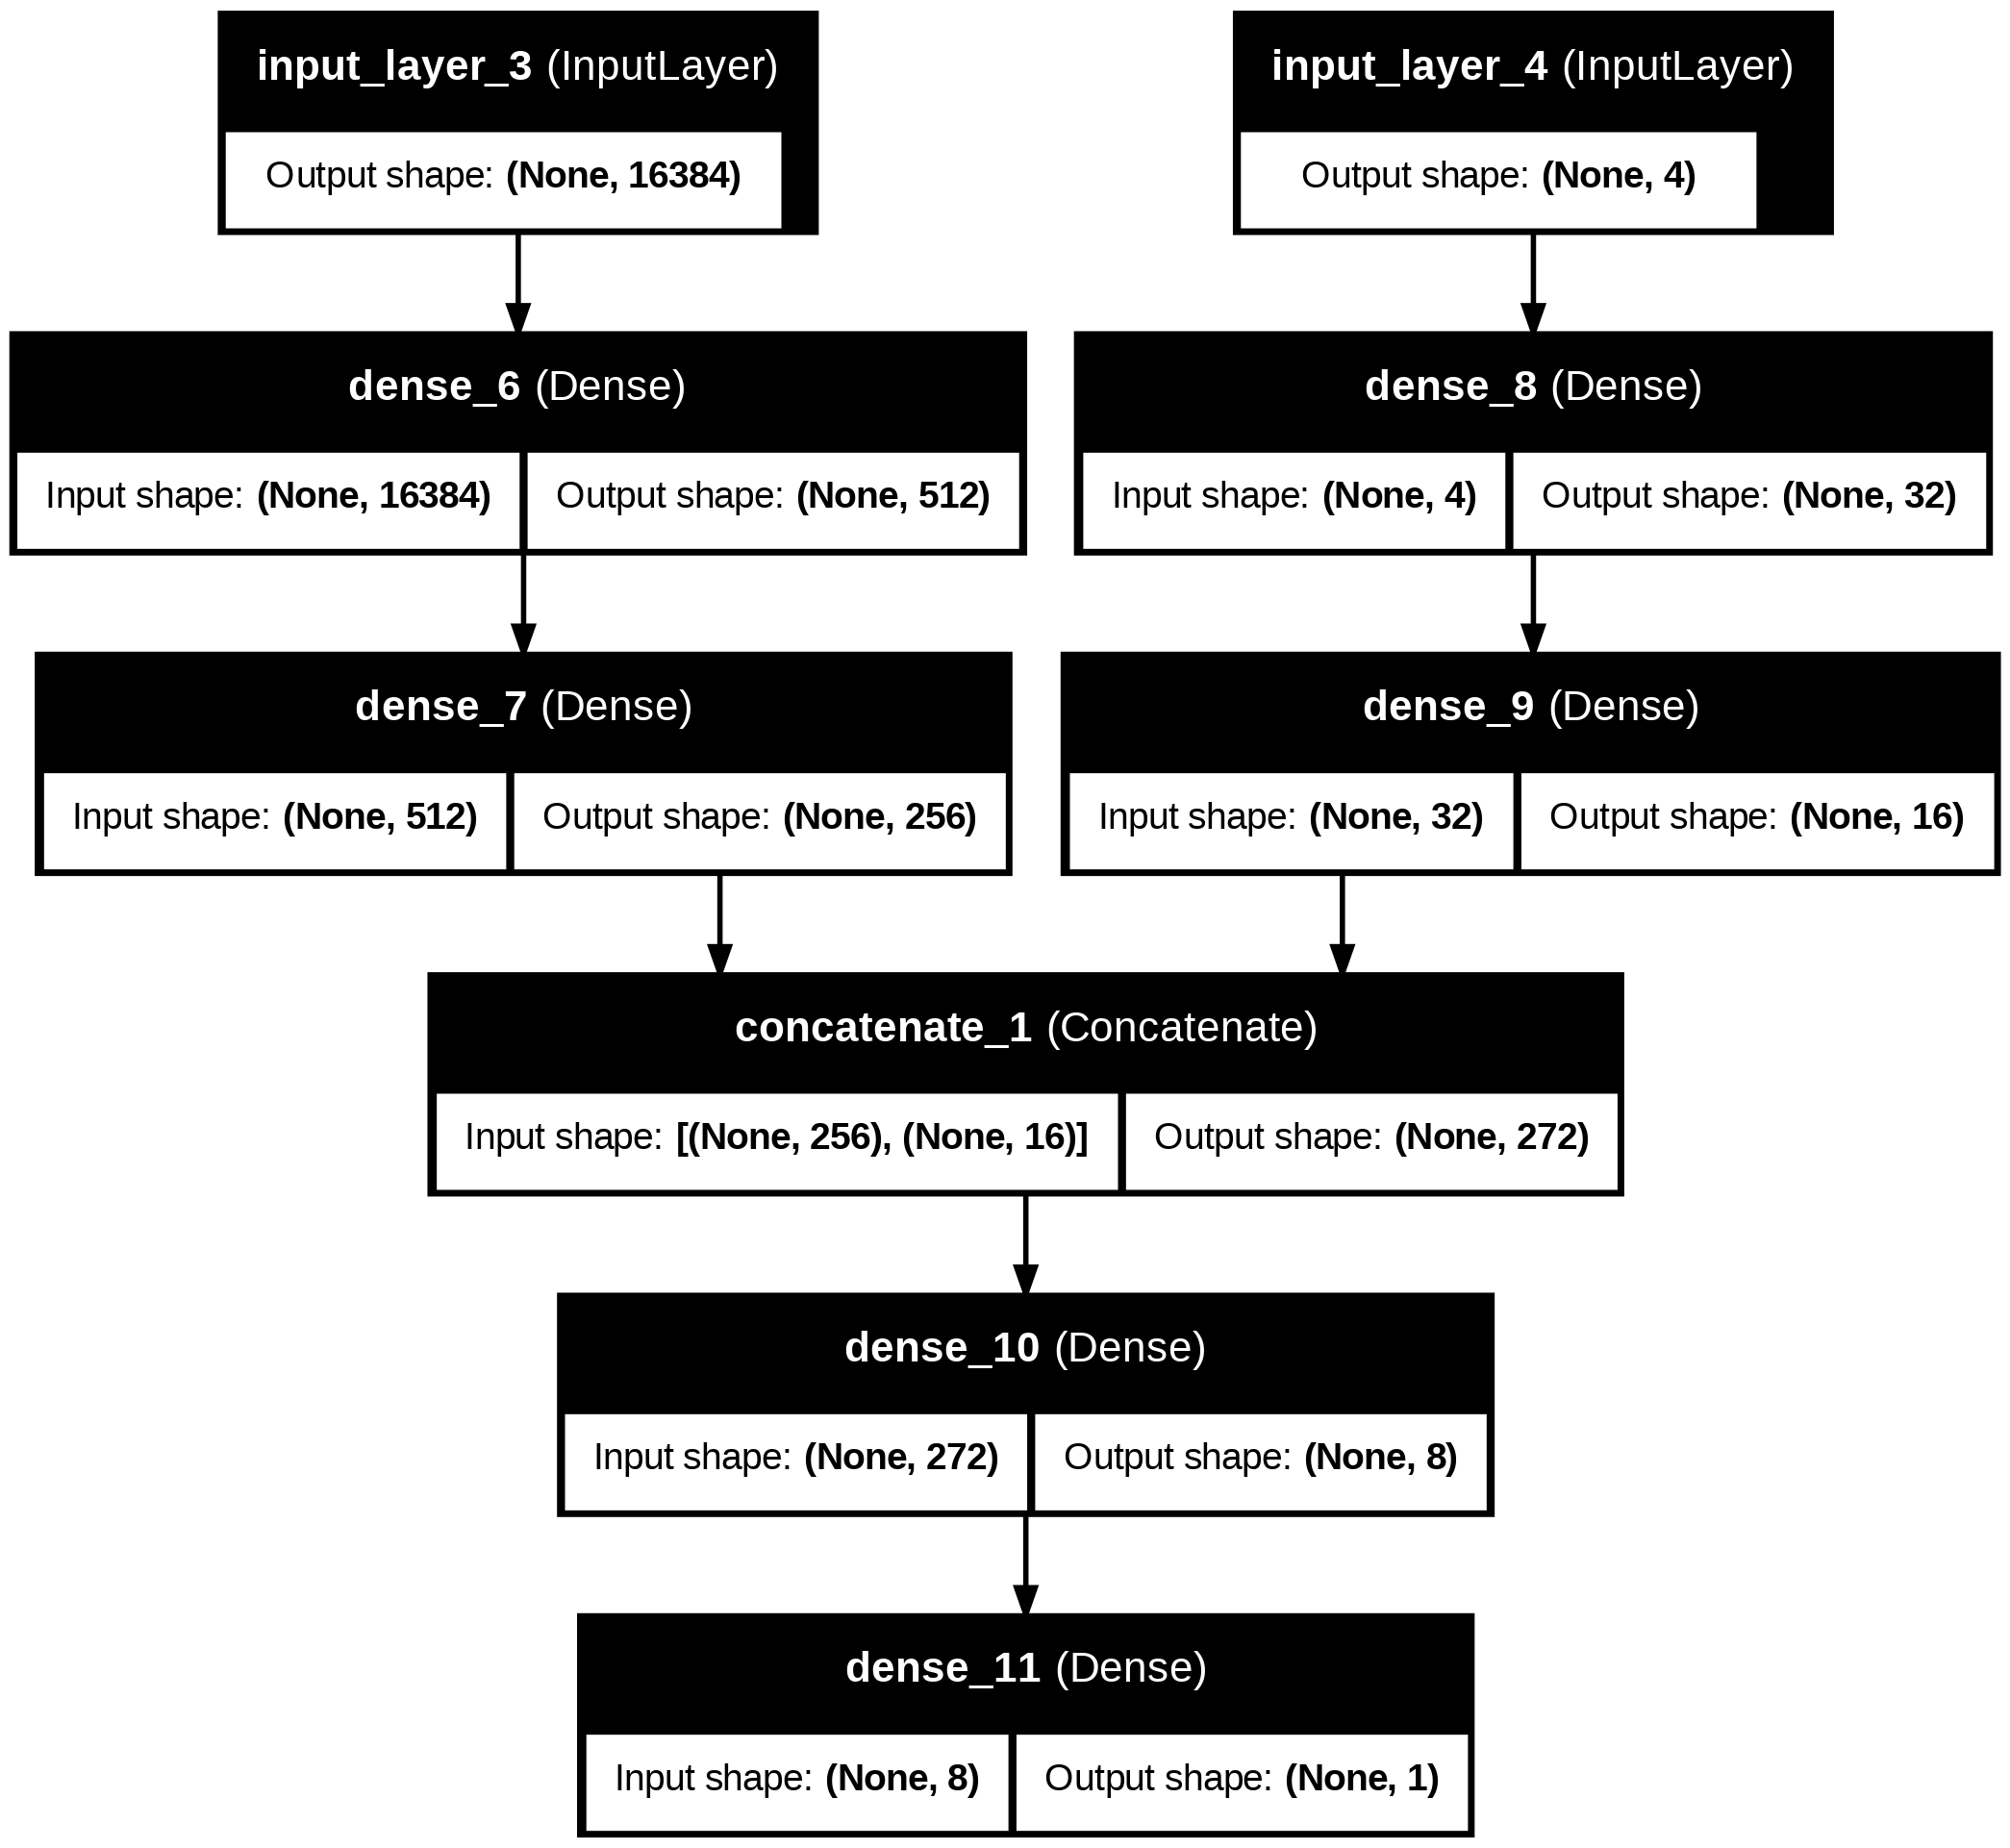

In [ ]:
plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 16384)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 512)            │      8,389,120 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 32)             │            160 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 256)            │        131,328 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 16)             │            528 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 272)            │              0 │ dense_7[0][0],         │
│ (Concatenate)             │                        │                │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 8)              │          2,184 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │              9 │ dense_10[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,523,329 (32.51 MB)

 Trainable params: 8,523,329 (32.51 MB)

 Non-trainable params: 0 (0.00 B)

# Train and Test Model

In [ ]:
model.fit([image_features_np,normlized_X],normlized_y,epochs=50,batch_size=32,validation_split=0.2)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - loss: 27.4155 - mae: 3.1184 - val_loss: 1.8145 - val_mae: 1.3295
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8620 - mae: 0.7934 - val_loss: 0.0488 - val_mae: 0.1741
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2360 - mae: 0.3907 - val_loss: 0.2125 - val_mae: 0.4275
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2345 - mae: 0.4167 - val_loss: 0.2678 - val_mae: 0.4905
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2667 - mae: 0.4465 - val_loss: 0.0790 - val_mae: 0.2409
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0692 - mae: 0.2063 - val_loss: 0.0436 - val_mae: 0.1733
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0387 - mae: 0.1593 - val_loss: 0.0174 - val_mae: 0.1074
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0154 - mae: 0.0978 - val_loss: 0.0147 - val_mae: 0.0978
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0100 - ma

In [ ]:
X_train = normlized_X[:450]
X_test = normlized_X[450:]

y_train = normlized_y[:450]
y_test = normlized_y[450:]

image_features_np_train = image_features_np[:450]
image_features_np_test = image_features_np[450:]

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape,image_features_np_train.shape,image_features_np_test.shape

((450, 4), (85, 4), (450, 1), (85, 1), (450, 16384), (85, 16384))

In [ ]:
es = EarlyStopping(monitor='val_loss',mode='min',patience=5)

In [ ]:
history = model.fit([image_features_np_train,X_train],y_train,epochs=50,batch_size=32,validation_split=0.2,callbacks=[es])

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 14.9537 - mae: 2.8805 - val_loss: 2.1056 - val_mae: 1.4004
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9887 - mae: 1.2126 - val_loss: 1.4536 - val_mae: 1.1660
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7052 - mae: 0.7036 - val_loss: 0.1370 - val_mae: 0.3176
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2819 - mae: 0.4262 - val_loss: 0.1165 - val_mae: 0.2828
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1376 - mae: 0.2943 - val_loss: 0.0435 - val_mae: 0.1512


In [ ]:
predictions = model.predict([image_features_np_test,X_test])
test_loss, test_mae = model.evaluate([image_features_np_test,X_test], y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0405 - mae: 0.1564 
Test Loss: 0.041711654514074326, Test MAE: 0.16283950209617615
